In [194]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [195]:
# Create a dataframe for our data and preview data types
df = pd.read_csv('flu_trends.csv')
df.dtypes,df

(Week         object
 FluVisits     int64
 dtype: object,
                       Week  FluVisits
 0    2009-06-29/2009-07-05        180
 1    2009-07-06/2009-07-12        115
 2    2009-07-13/2009-07-19        132
 3    2009-07-20/2009-07-26        109
 4    2009-07-27/2009-08-02        120
 ..                     ...        ...
 361  2016-05-30/2016-06-05         90
 362  2016-06-06/2016-06-12         55
 363  2016-06-13/2016-06-19         33
 364  2016-06-20/2016-06-26         27
 365  2016-06-27/2016-07-03         22
 
 [366 rows x 2 columns])

In [196]:
# Convert Week column to datetime
df['Week'] = pd.to_datetime(df['Week'])
df.set_index(
    pd.PeriodIndex(df.Week,freq="W"),
    inplace=False)
df = df.drop('Week',axis=1)

In [197]:
# preview datatypes and dataset
df.dtypes,df

(FluVisits    int64
 dtype: object,
      FluVisits
 0          180
 1          115
 2          132
 3          109
 4          120
 ..         ...
 361         90
 362         55
 363         33
 364         27
 365         22
 
 [366 rows x 1 columns])

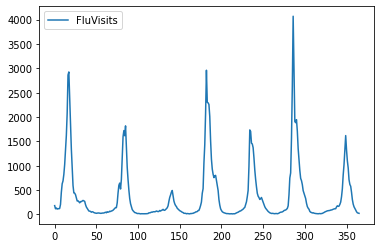

In [198]:
# plot original data
df.plot()
plt.show()

In [199]:
# prepare data for multi-output regression model
df2 = df.copy()
# Create lag features
df2['lag1'] = df['FluVisits'].shift(1).dropna()
df2['lag2'] = df['FluVisits'].shift(2).dropna()
df2['lag3'] = df['FluVisits'].shift(3).dropna()
# Create multistep targets
df2['y1'] = df['FluVisits']
df2['y2'] = df['FluVisits'].shift(-1).dropna()
df2['y3'] = df['FluVisits'].shift(-2).dropna()
df2['y4'] = df['FluVisits'].shift(-3).dropna()
df2['y5'] = df['FluVisits'].shift(-4).dropna()
df2 = df2.dropna()
df2 = df2.drop(columns=['FluVisits'])
# Add week column
df2['Week'] = np.arange(len(df2.index))
df2

,lag1,lag2,lag3,y1,y2,y3,y4,y5,Week
3,132.0,115.0,180.0,109,120.0,115.0,123.0,205.0,0
4,109.0,132.0,115.0,120,115.0,123.0,205.0,454.0,1
5,120.0,109.0,132.0,115,123.0,205.0,454.0,628.0,2
6,115.0,120.0,109.0,123,205.0,454.0,628.0,687.0,3
7,123.0,115.0,120.0,205,454.0,628.0,687.0,821.0,4
...,...,...,...,...,...,...,...,...,...
357,455.0,578.0,616.0,305,211.0,156.0,124.0,90.0,354
358,305.0,455.0,578.0,211,156.0,124.0,90.0,55.0,355
359,211.0,305.0,455.0,156,124.0,90.0,55.0,33.0,356
360,156.0,211.0,305.0,124,90.0,55.0,33.0,27.0,357


In [208]:
# Create arrays for models
X = df2.drop(['y1','y2','y3','y4','y5','Week'],axis=1) # lag features
y = df2.drop(['lag1','lag2','lag3','Week'],axis=1) # multistep targets
X.head(),y.head()

(    lag1   lag2   lag3
 3  132.0  115.0  180.0
 4  109.0  132.0  115.0
 5  120.0  109.0  132.0
 6  115.0  120.0  109.0
 7  123.0  115.0  120.0,
     y1     y2     y3     y4     y5
 3  109  120.0  115.0  123.0  205.0
 4  120  115.0  123.0  205.0  454.0
 5  115  123.0  205.0  454.0  628.0
 6  123  205.0  454.0  628.0  687.0
 7  205  454.0  628.0  687.0  821.0)

In [209]:
# Simple Linear Regression Model
l = LinearRegression()
l.fit(X,y)
pred = l.predict(X)

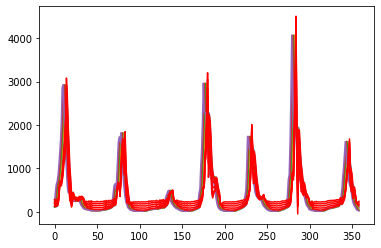

In [210]:
plt.plot(df2.Week,y.values)
plt.plot(df2['Week'],pred,c='r')
plt.show()

In [211]:
# Direct multi output model
model = LinearSVR()
wrapper = MultiOutputRegressor(model)
wrapper.fit(X,y)
pred_V2 = wrapper.predict(X)

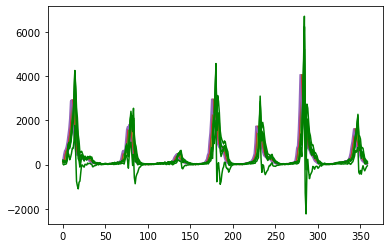

In [212]:
plt.plot(df2.Week,y.values)
plt.plot(df2['Week'],pred_V2,c='g')
plt.show()

In [213]:
# Chained multi output model
wrapper2 = RegressorChain(model,order=[0,1,2,3,4])
wrapper2.fit(X,y)
pred_V3 = wrapper2.predict(X)

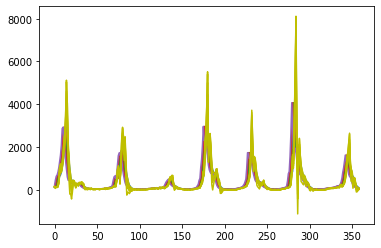

In [204]:
plt.plot(df2.Week,y.values)
plt.plot(df2['Week'],pred_V3,c='y')
plt.show()

In [205]:
print(f"RMSE for simple Linear Regression: {np.sqrt(mean_squared_error(y,pred))}")

RMSE for simple Linear Regression: 385.06354839585055


In [206]:
print(f"RMSE for direct multi output: {np.sqrt(mean_squared_error(y,pred_V2))}")

RMSE for direct multi output: 486.3378690837695


In [207]:
print(f"RMSE for chained multi output: {np.sqrt(mean_squared_error(y,pred_V3))}")

RMSE for chained multi output: 555.2529442976221
